### This is a playground to experiment code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from dot import viz
import torch
import random

from typing import Union

In [2]:
a = 5
b = 9
c = 10

y = a * b + c

print(y)

55


In [709]:
class Value:
    # data should be simple numeric value (e.g. int or float)
    def __init__(self, data, prevs=[], ops='', label=''):
        self.data = data
        self.prevs = prevs
        self.ops = ops
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return str(f'Value(data: {self.data})')

    def __str__(self):
        return self.__repr__()

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, [self, other], '+')

        def add_backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
        result._backward = add_backward
        return result

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data - other.data, [self, other], '-')

        def sub_backward():
            self.grad += 1.0 * result.grad
            other.grad += -1.0 * result.grad
        result._backward = sub_backward
        return result

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, [self, other], '*')

        def mul_backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        result._backward = mul_backward

        return result

    def __truediv__(self, other):
        return self * other**-1
        # other = other if isinstance(other, Value) else Value(other)
        # result = Value(self.data / other.data, [self, other], '/')

        # def truediv_backward():
        #     self.grad += math.pow(other.data, -1) * result.grad
        #     other.grad += -self.data * \
        #         math.pow(other.data, -2) * result.grad
        # result._backward = truediv_backward

        # return result

    def __pow__(self, other, modulo=None):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(math.pow(self.data, other.data), [self, other], '**')

        def pow_backward():
            self.grad += other.data * \
                math.pow(self.data, other.data - 1) * result.grad
        result._backward = pow_backward

        return result

    def __radd__(self, other):
        return Value(other) + self

    def __rsub__(self, other):
        return Value(other) - self

    def __rmul__(self, other):
        return Value(other) * self

    def __rtruediv__(self, other):
        return Value(other) / self

    def __rpow__(self, other):
        return Value(other) ** self

    def _zero_grad(self):
        self.grad = 0

    def exp(self):
        exp = math.exp(self.data)
        result = Value(exp, [self], 'exp')

        def exp_backward():
            self.grad += exp * result.grad
        result._backward = exp_backward

        return result

    def backward(self):
        self.grad = 1.0
        visited = set()
        topo = []

        def DFS(cur):
            if cur in visited:
                return
            visited.add(cur)
            for prev in cur.prevs:
                DFS(prev)
            topo.append(cur)

        DFS(self)
        for node in reversed(topo):
            node._backward()

    def id(self):
        return str(id(self))

In [8]:
a = Value(5, label='a')
b = Value(9, label='b')
c = Value(10, label='c')
e = Value(11, label='e')
f = Value(15, label='f')
d = a * b
d.label = 'd'
g = e / f
g.label = 'g'
y = d + c - g
y.label = 'y'

y.backward()

print(y)
print(f'a.grad: {a.grad}')
print(f'b.grad: {b.grad}')
print(f'c.grad: {c.grad}')
print(f'e.grad: {e.grad}')
print(f'f.grad: {f.grad}')

Value(data: 54.266666666666666)
a.grad: 9.0
b.grad: 5.0
c.grad: 1.0
e.grad: -0.06666666666666667
f.grad: 0.04888888888888889


In [7]:
at = torch.tensor(5.0, requires_grad=True)
bt = torch.tensor(9.0, requires_grad=True)
ct = torch.tensor(10.0, requires_grad=True)
et = torch.tensor(11.0, requires_grad=True)
ft = torch.tensor(15.0, requires_grad=True)

dt = at * bt
yt = dt + ct - et / ft

yt.backward()

print(f'yt: {yt}')
print(f'at.grad: {at.grad}')
print(f'bt.grad: {bt.grad}')
print(f'ct.grad: {ct.grad}')
print(f'et.grad: {et.grad}')
print(f'ft.grad: {ft.grad}')

yt: 54.266666412353516
at.grad: 9.0
bt.grad: 5.0
ct.grad: 1.0
et.grad: -0.06666667014360428
ft.grad: 0.04888888821005821


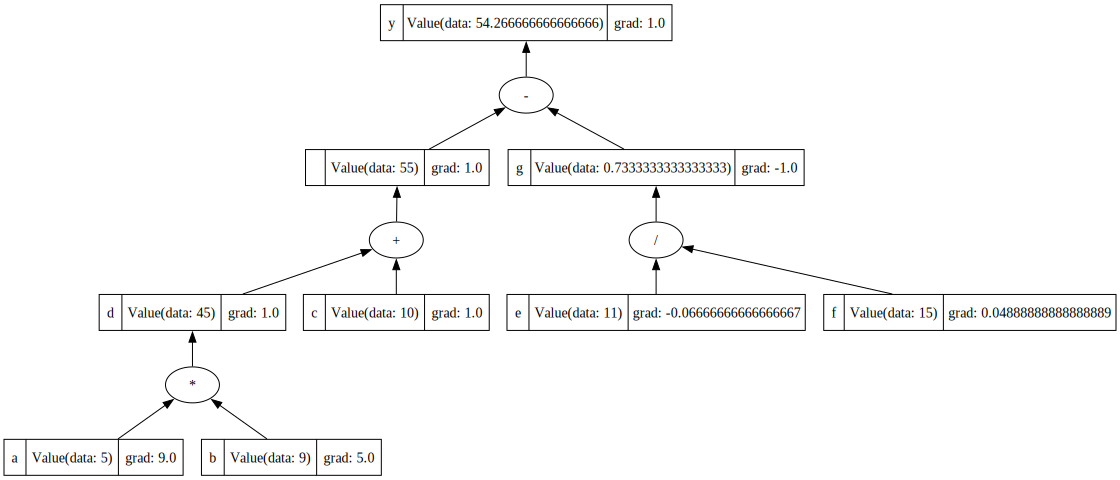

In [9]:
dot = viz.generate_graph(y)
dot

In [468]:
at = torch.tensor(5.0, requires_grad=True)
bt = torch.tensor(9.0, requires_grad=True)
ct = torch.tensor(10.0, requires_grad=True)
et = torch.tensor(11.0, requires_grad=True)
ft = torch.tensor(15.0, requires_grad=True)

yt = at * bt + ct - et / ft + at * ct**2

yt.backward()

print(f'yt: {yt}')
print(f'at.grad: {at.grad}')
print(f'bt.grad: {bt.grad}')
print(f'ct.grad: {ct.grad}')
print(f'et.grad: {et.grad}')
print(f'ft.grad: {ft.grad}')

yt: 554.2666625976562
at.grad: 109.0
bt.grad: 5.0
ct.grad: 101.0
et.grad: -0.06666667014360428
ft.grad: 0.04888888821005821


In [12]:
a = Value(5, label='a')
b = Value(9, label='b')
c = Value(10, label='c')
e = Value(11, label='e')
f = Value(15, label='f')
y = a * b + c - e / f + a * c**2
y.label = 'y'

y.backward()

print(y)
print(f'a.grad: {a.grad}')
print(f'b.grad: {b.grad}')
print(f'c.grad: {c.grad}')
print(f'e.grad: {e.grad}')
print(f'f.grad: {f.grad}')

Value(data: 554.2666666666667)
a.grad: 109.0
b.grad: 5.0
c.grad: 101.0
e.grad: -0.06666666666666667
f.grad: 0.04888888888888889


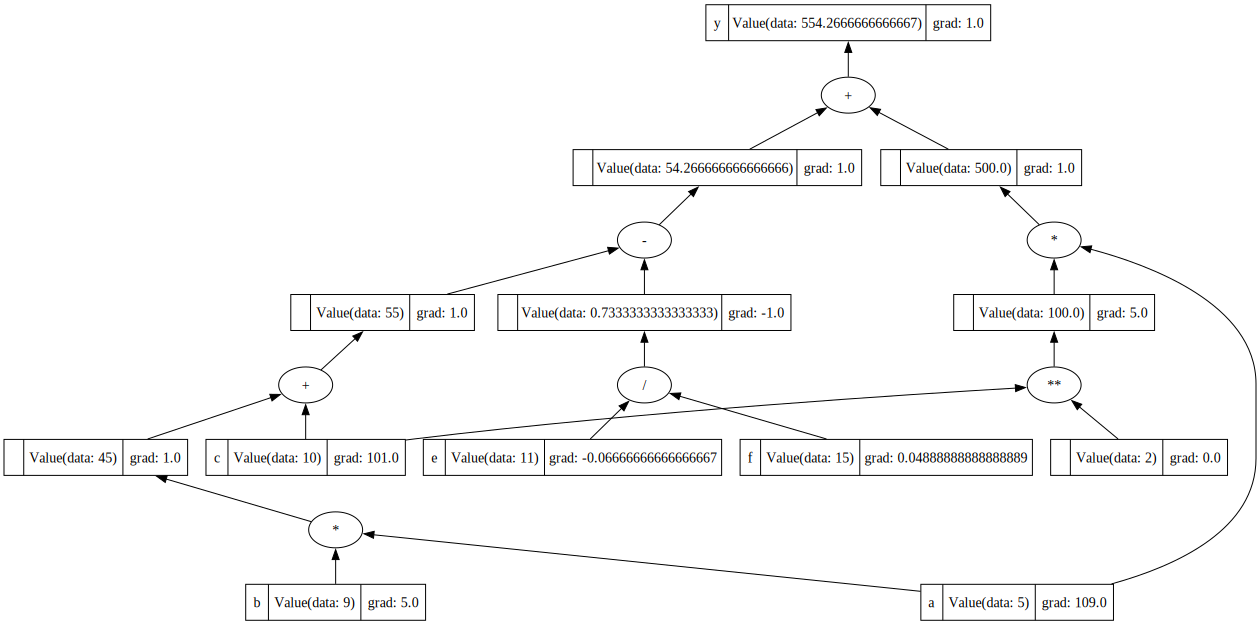

In [36]:
dot = viz.generate_graph(y)
dot

In [18]:
at = torch.tensor(5.0, requires_grad=True)
(at*2).exp()

tensor(22026.4648, grad_fn=<ExpBackward0>)

In [19]:
a = Value(5)
(a*Value(2)).exp()

Value(data: 22026.465794806718)

In [20]:
at = torch.tensor(5.0, requires_grad=True)
yt = (at*2).exp()
yt.backward()
at.grad

tensor(44052.9297)

In [22]:
a = Value(5)
y = (a*Value(2)).exp()
y.backward()
a.grad

44052.931589613436

In [724]:
def tanh(x):
    exp = math.exp(x.data * 2)
    out = (exp - 1) / (exp + 1)
    result = Value(out, prevs=[x], ops='tanh')

    def tanh_backward():
        x.grad += (1 - out ** 2) * result.grad
    result._backward = tanh_backward
    return result


def tanh_raw(x):
    x2exp = (x * Value(2)).exp()
    return (x2exp - Value(1)) / (x2exp + Value(1))

In [718]:
a = Value(3, label='a')
y = tanh(a)
y.label = 'y'
print(y)
y.backward()
print(a.grad)
print(1 - y.data ** 2)

Value(data: 0.9950547536867305)
0.009866037165440211
0.009866037165440211


In [719]:
at = torch.tensor(3.0, requires_grad=True)
yt = torch.tanh(at)
print(yt)
yt.backward()
print(at.grad)

tensor(0.9951, grad_fn=<TanhBackward0>)
tensor(0.0099)


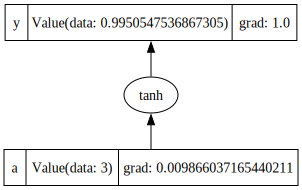

In [55]:
dot = viz.generate_graph(y)
dot

In [59]:
a = Value(5)
y1 = 1 - a
y2 = 1 + a

print(y1)
print(y2)

Value(data: -4)
Value(data: 6)


In [61]:
a = Value(5)
y = 10 * a

print(y)

Value(data: 50)


In [64]:
a = Value(5)
y = 10 / a

print(y)

Value(data: 2.0)


In [71]:
a = Value(5)
y = 10 ** a

print(y)

Value(data: 100000.0)


In [567]:
# loss function
# MSE
def mse_loss(y_hat, y):
    return sum([(yh - ys) ** 2 for yh, ys in zip(y_hat, y)]) / len(y_hat)


y_hat = [0, 1, 0, 1]
y = [1, 1, 0, 0]
print(mse_loss(y_hat, y))

0.5


In [451]:
mse = torch.nn.MSELoss()

predicted = torch.tensor([0, 1, 0, 1], dtype=torch.float32)
target = torch.tensor([1, 1, 0, 0], dtype=torch.float32)

print(mse(predicted, target))

tensor(0.5000)


In [525]:
np.random.normal(2, 0.1)

1.921617268727721

[4.834639413753152, 8.23340335448932, 10.71449034825963, 14.146306711600428]


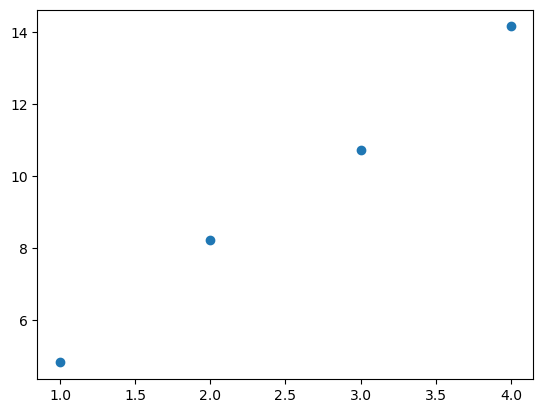

In [650]:
# linear regression with 1 input
w = Value(1.0, label='w')
b = Value(0, label='b')

w_gt = 3.0
b_gt = 2.0

X = [i for i in range(1, 5)]
y = [ w_gt * x + b_gt + np.random.normal(0, 0.1) for x in X]

print(y)
plt.scatter(X, y)


In [677]:
def forward(X):
    return [w * x + b for x in X]

def training_step():
    lr = 0.1

    y_hat = forward(X)
    loss = mse_loss(y_hat, y)
    print(loss)

    w._zero_grad()
    b._zero_grad()

    loss.backward()

    w.data -= lr * w.grad
    b.data -= lr * b.grad

for i in range(10):
    training_step()

Value(data: 0.04370510313830174)
Value(data: 0.043705100355698814)
Value(data: 0.043705097737218444)
Value(data: 0.043705095273180665)
Value(data: 0.04370509295447606)
Value(data: 0.043705090772532484)
Value(data: 0.0437050887192837)
Value(data: 0.04370508678713908)
Value(data: 0.04370508496895565)
Value(data: 0.043705083258011986)


Value(data: 3.041742277017625) Value(data: 1.8777955573692888)


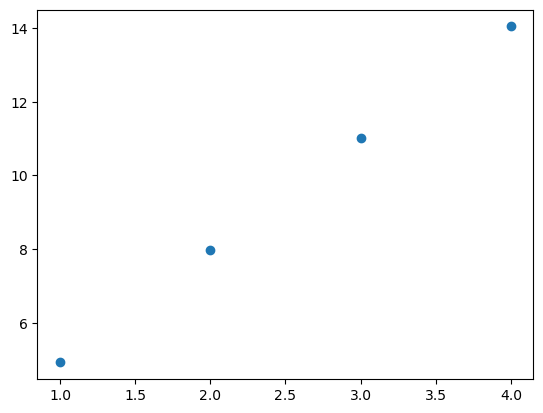

In [678]:
y_hat = forward(X)

print(w, b)

plt.scatter(X, [yh.data for yh in y_hat])

In [752]:
# Linear regression with 3 input features, with tanh activation function


w0 = Value(-2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(3.0, label='w2')
b = Value(0, label='b')

W = [w0, w1, w2]

w0gt = Value(1.0, label='w0gt')
w1gt = Value(3.0, label='w1gt')
w2gt = Value(-2.0, label='w2gt')
bgt = Value(-3.0, label='bgt')

W_gt = [w0gt, w1gt, w2gt]


# def forward(x, W, b):
#     o = W[0] * x[0] + W[1] * x[1] + W[2] * x[2] + b
#     return tanh(o)

def forward(x, W, b):
    return tanh(W[0] * x[0] + W[1] * x[1] + W[2] * x[2] + b)


X = [[2.0, -1.0, 3.0], [1.0, 5.0, -2.0], [1.0, -0.5, 4.0], [-1.0, -2.5, 2.0]]
y = [forward(x, W_gt, bgt) for x in X]

print(y)

# for x in X:
#     y.append(forward(x, W_gt, bgt))
# print(y)

[Value(data: -0.9999999958776927), Value(data: 0.9999999999999966), Value(data: -0.9999999997947624), Value(data: -0.9999999999999312)]


In [749]:
def training_step():
    y_hat = []

    for x in X:
        y_hat.append(forward(x, W, b))

    loss = mse_loss(y_hat, y)

    print(f'loss: {loss.data}')

    for w in W:
        w._zero_grad()
    b._zero_grad()


    loss.backward()

    # for p in params:
    #     print(f'{p.label}.grad: {p.grad}')

    for w in W:
        w.data -= 0.1 * w.grad
    b.data -= 0.1 * b.grad


for i in range(100):
    training_step()

loss: 3.994356861654196
loss: 3.9940203164497206
loss: 3.9936392854210707
loss: 3.993204379432906
loss: 3.9927033957833107
loss: 3.9921201907624364
loss: 3.9914329689038537
loss: 3.9906116076112768
loss: 3.9896133249667973
loss: 3.988375373746443
loss: 3.9868021141657737
loss: 3.9847407835927737
loss: 3.9819327674770233
loss: 3.9779065903500785
loss: 3.9717148136008724
loss: 3.961182208761264
loss: 3.940257925676912
loss: 3.88637909820074
loss: 3.671036910999238
loss: 3.0273396948162956
loss: 3.000869728455128
loss: 2.9960265176439216
loss: 2.9932334690448004
loss: 2.9911665675324572
loss: 2.989412028688991
loss: 2.987783833653534
loss: 2.9861747993487366
loss: 2.9845078902609323
loss: 2.982715096001428
loss: 2.98072498989819
loss: 2.9784521484963196
loss: 2.9757845645803345
loss: 2.9725650263015373
loss: 2.968559895083111
loss: 2.963402075219749
loss: 2.956478385844954
loss: 2.946687043658091
loss: 2.9318576450455054
loss: 2.907166686017301
loss: 2.8600060396227636
loss: 2.74971097646

In [750]:
for x in X:
    print(forward(x, W, b))

Value(data: -0.9999859410035564)
Value(data: 0.9999999739971578)
Value(data: -0.9331543002148442)
Value(data: -0.9984563133235667)


We don't have enough training example to learn a non-linear function correctly

In [751]:
print(W, b)

[Value(data: -2.3091308121055474), Value(data: 2.6363741175749107), Value(data: 0.6231155674939913)] Value(data: -0.5474050616267833)


In [727]:
w0 = Value(-2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(3.0, label='w2')
b = Value(0, label='b')

x = [2.0, -1.0, 1.0]

y_hat = tanh(w0 * x[0] + w1 * x[1] + w2 * x[2] + b)
y = 1.0

loss = mse_loss([y_hat], [y])
loss.backward()
# y_hat.backward()

print(y_hat)
print(loss)
print(w0.grad)
print(w1.grad)
print(w2.grad)
print(b.grad)

Value(data: -0.9640275800758168)
Value(data: 3.8574043352984693)
-0.5550406742668854
0.2775203371334427
-0.2775203371334427
-0.2775203371334427


In [726]:
w0t = torch.tensor(-2.0, dtype=torch.float, requires_grad=True)
w1t = torch.tensor(1.0, dtype=torch.float, requires_grad=True)
w2t = torch.tensor(3.0, dtype=torch.float, requires_grad=True)
bt = torch.tensor(0, dtype=torch.float, requires_grad=True)

x = [2.0, -1.0, 1.0]

y_hat_t = torch.tanh(w0t * x[0] + w1t * x[1] + w2t * x[2] + bt)
y_t = torch.tensor(1.0, dtype=torch.float)

loss_t = torch.nn.MSELoss()(y_hat_t, y_t)
loss_t.backward()
# y_hat_t.backward()

print(y_hat_t)
print(loss_t)
print(w0t.grad)
print(w1t.grad)
print(w2t.grad)
print(bt.grad)

tensor(-0.9640, grad_fn=<TanhBackward0>)
tensor(3.8574, grad_fn=<MseLossBackward0>)
tensor(-0.5550)
tensor(0.2775)
tensor(-0.2775)
tensor(-0.2775)


In [ ]:
w0 = Value(-2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(3.0, label='w2')
b = Value(0, label='b')

x = [2.0, -1.0, 1.0]

y_hat = tanh(w0 * x[0] + w1 * x[1] + w2 * x[2] + b)
y = 1.0

loss = mse_loss([y_hat], [y])
loss.backward()

In [766]:
class Neuron:
    def __init__(self, n_input):
        self.W = [Value(random.uniform(-1, 1)) for _ in range(n_input)]
        self.b = Value(0)
        self.n_input = n_input

    def __call__(self, x):        
        o = sum([ wi * xi for wi, xi in zip(x, self.W)]) + b
        return tanh(o)
    
    def parameters(self):
        return self.W + [self.b]

In [769]:
n = Neuron(3)
print(n.parameters())
print(n.W)
x = [1, 2, 3]
print(n(x))

[Value(data: -0.029722512228810283), Value(data: 0.3830823495129827), Value(data: 0.2797121952173762), Value(data: 0)]
[Value(data: -0.029722512228810283), Value(data: 0.3830823495129827), Value(data: 0.2797121952173762)]
Value(data: 0.9179086161430178)


In [776]:
class Layer:
    def __init__(self, n_input, n_output):
        self.neurons = [Neuron(n_input) for _ in range(n_output)]
        self.n_input = n_input
        self.n_output = n_output

    def __call__(self, x):
        return [neuron(x) for neuron in self.neurons]
    
    def parameters(self):
        p = []
        for n in self.neurons:
            p.extend(n.parameters())
        return p

In [777]:
l = Layer(4, 2)
x = [1, 2, 3, 4]
print(l.parameters())
print(l(x))

[Value(data: -0.5292465768230299), Value(data: -0.45734735337235155), Value(data: 0.054663748681275104), Value(data: 0.2295202354510526), Value(data: 0), Value(data: -0.6159304604044527), Value(data: 0.932222786573875), Value(data: -0.14378265290496994), Value(data: 0.25644875616704166), Value(data: 0)]
[Value(data: -0.3468593210991216), Value(data: 0.9510786791805815)]


In [790]:
class MLP:
    def __init__(self, n_input, layer_sizes):
        input = n_input
        self.layers = []
        for ls in layer_sizes:
            self.layers.append(Layer(input, ls))
            input = ls
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        p = []
        for l in self.layers:
            p.extend(l.parameters())
        return p

In [791]:
mlp = MLP(4, [3, 2, 1])
x = [1, 2, 3, 4]
print(mlp(x))
print(mlp.parameters())

[Value(data: -0.35342652073758646)]
[Value(data: -0.7877648150725356), Value(data: -0.1019750792326648), Value(data: -0.6138170219686252), Value(data: 0.7172706492352368), Value(data: 0), Value(data: -0.7376316014594002), Value(data: 0.5378089122398146), Value(data: -0.458007748479732), Value(data: -0.2420086655630853), Value(data: 0), Value(data: 0.1304011894168986), Value(data: 0.2964682046509186), Value(data: 0.569683208011452), Value(data: 0.9028655991010066), Value(data: 0), Value(data: 0.6822604273969564), Value(data: -0.15254434580487608), Value(data: -0.37986908545349474), Value(data: 0), Value(data: 0.24020344431697382), Value(data: 0.21835321668264673), Value(data: 0.7982944978272764), Value(data: 0), Value(data: -0.4342508056050147), Value(data: -0.8579169878553072), Value(data: 0)]


In [792]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [793]:
n = MLP(3, [4, 4, 1])

for k in range(100):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 4.535558432159193
1 3.1527115071848946
2 1.8279343739573233
3 0.45339187321411
4 0.20997757559349564
5 0.13880722696019338
6 0.1031265886020224
7 0.08170431953179544
8 0.06744687241091532
9 0.057294089023589165
10 0.04970851010766776
11 0.04383343813000716
12 0.03915404175653436
13 0.035342521118364154
14 0.032180387263016696
15 0.029516492404243568
16 0.027242998640872613
17 0.025280939781660464
18 0.02357119024138499
19 0.02206861923821759
20 0.02073819352547801
21 0.01955231154913064
22 0.01848893828301778
23 0.01753027387756332
24 0.016661786212583136
25 0.015871496513475115
26 0.01514944413165474
27 0.014487280242817691
28 0.01387795568558618
29 0.013315478476592084
30 0.012794723536093679
31 0.012311281983606264
32 0.011861340739840985
33 0.011441585566803525
34 0.011049122398929781
35 0.010681413069137623
36 0.0103362224529934
37 0.01001157473667882
38 0.009705717025961805
39 0.00941708890018886
40 0.009144296810293493
41 0.008886092446540737
42 0.0086413543772985
43 0.0084090

In [794]:
ypred

[[Value(data: 0.9792908093800771)],
 [Value(data: -0.9628117837872897)],
 [Value(data: -0.9736613410768513)],
 [Value(data: 0.9730156307730895)]]